# CLASSIFICATION : LOAN APPLICATION

## PRACTICES IN THIS NOTEBOOK

In this notebook, I will guide you through the complete process of building and evaluating a classification model, explaining each step in detail. Unlike the regression models in my previous notebooks, where the focus was mainly on the model outputs, this notebook will take a more methodological approach. By walking through every stage—from data preprocessing to model selection, training, and evaluation—you’ll gain insight into how to effectively apply classification techniques to solve real-world problems.

By the end of this notebook, you’ll have a comprehensive understanding of the methodology involved in classification modeling, including key concepts such as data preparation, feature engineering, model selection, evaluation metrics, and fine-tuning techniques.

# Introduction

**Problem Statement**

**About Company**

Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

**Problem**

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

**Metric**

Metric of this problem is ROC-AUC score.

# Methodology - Step by step

1. **Load the Data:** Import both the training and test datasets, and check their shapes to ensure they are loaded correctly.
2. **Preview the Data:** Display the first few rows of the datasets to understand their structure and contents using `head()`.
3. **Identify Missing Values:** List any missing values in both the training and test sets to assess the completeness of the data.
4. **Check for Duplicates:** Ensure there are no duplicated rows in the datasets.
5. **Conduct Exploratory Data Analysis (EDA):** Begin with analyzing the distribution of the target variable, `loan_status`, by plotting its value counts.
6. **Address Class Imbalance:** Observe any imbalance in the target variable and examine how the independent categorical variables influence the target using a seaborn heatmap to visualize their relationships.
7. **Interpret the Heatmap:** Provide insights and observations based on the patterns identified in the heatmap.
8. **Visualize Relationships:** Use KDE plots to explore the relationships between numerical features and the target variable (`loan_status` 0 and 1).
9. **Identify Patterns:** Look for similar patterns or trends across different plots to deepen the understanding of the data.
10. **Detect Outliers:** Use scatter plots to visually inspect the numerical variables for potential outliers. Keep the plot in the notebook if outliers are present, otherwise, remove the plot and add a note explaining why.
11. **Optimize Data Types:** Convert data types to more efficient formats to optimize memory usage.
12. **Handle Outliers:** Apply the `clip()` function to address extreme values that may represent incorrect or anomalous data.
13. **Define Features and Target:** Specify the independent variables `X` and the target variable `y` for modeling.
14. **Use Stratified K-Fold Cross-Validation:** Implement stratified K-fold to ensure balanced class representation in each fold during model training.
15. **Apply Encoding:** Transform categorical variables using appropriate encoding techniques to prepare the data for modeling.
16. **Try Multiple Models:** Experiment with LightGBM (LGBM), XGBoost, and CatBoost to identify the best performing model.
17. **Optimize Hyperparameters:** Utilize Optuna to perform hyperparameter tuning for optimal model performance.
18. **Train Models:** Train the models using the best parameters identified during the optimization process.
19. **Make Predictions:** Proceed to predict the target variable on the test data using the trained models.

# 1. Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import optuna

# 2. Load Data

In [12]:
train_main = pd.read_csv("train.csv")
test_main = pd.read_csv("test.csv")
train = train_main.copy()
test = test_main.copy()

print("Loaded!")

Loaded!


In [13]:
print("Shape of training dataset: ", train.shape)
print("Shape of testing dataset: ", test.shape)

Shape of training dataset:  (58645, 13)
Shape of testing dataset:  (39098, 12)


In [14]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# 3. Explatory Data Analysis

In [16]:
def missing_values(df, name):
    print(f'--- {name} ---\n')
    print(df.isna().sum(),'\n')

missing_values(train, 'Train Missing Values')
missing_values(test, 'Test Missing Values')

--- Train Missing Values ---

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64 

--- Test Missing Values ---

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64 



In [17]:
def duplicated_values(df, name):
    print(f'{name} dataset has {df.duplicated().sum()} duplicated values.')

duplicated_values(train, "Train")
duplicated_values(test, "Test")

Train dataset has 0 duplicated values.
Test dataset has 0 duplicated values.


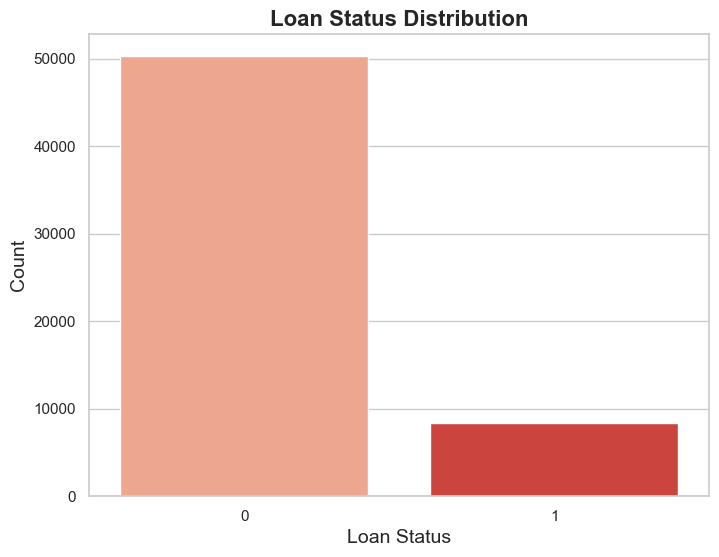

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style for the plots
sns.set(style="whitegrid")

# Create a bar plot for the loan_status column
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='loan_status', data=train, palette='Reds')

# Add title and labels
ax.set_title('Loan Status Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('Loan Status', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

plt.show()

From the bar plot, it can be seen that loan_status is an imbalanced value. Now we will examine how the independent categorical variables influence the target using a seaborn heatmap to visualize their relationships.

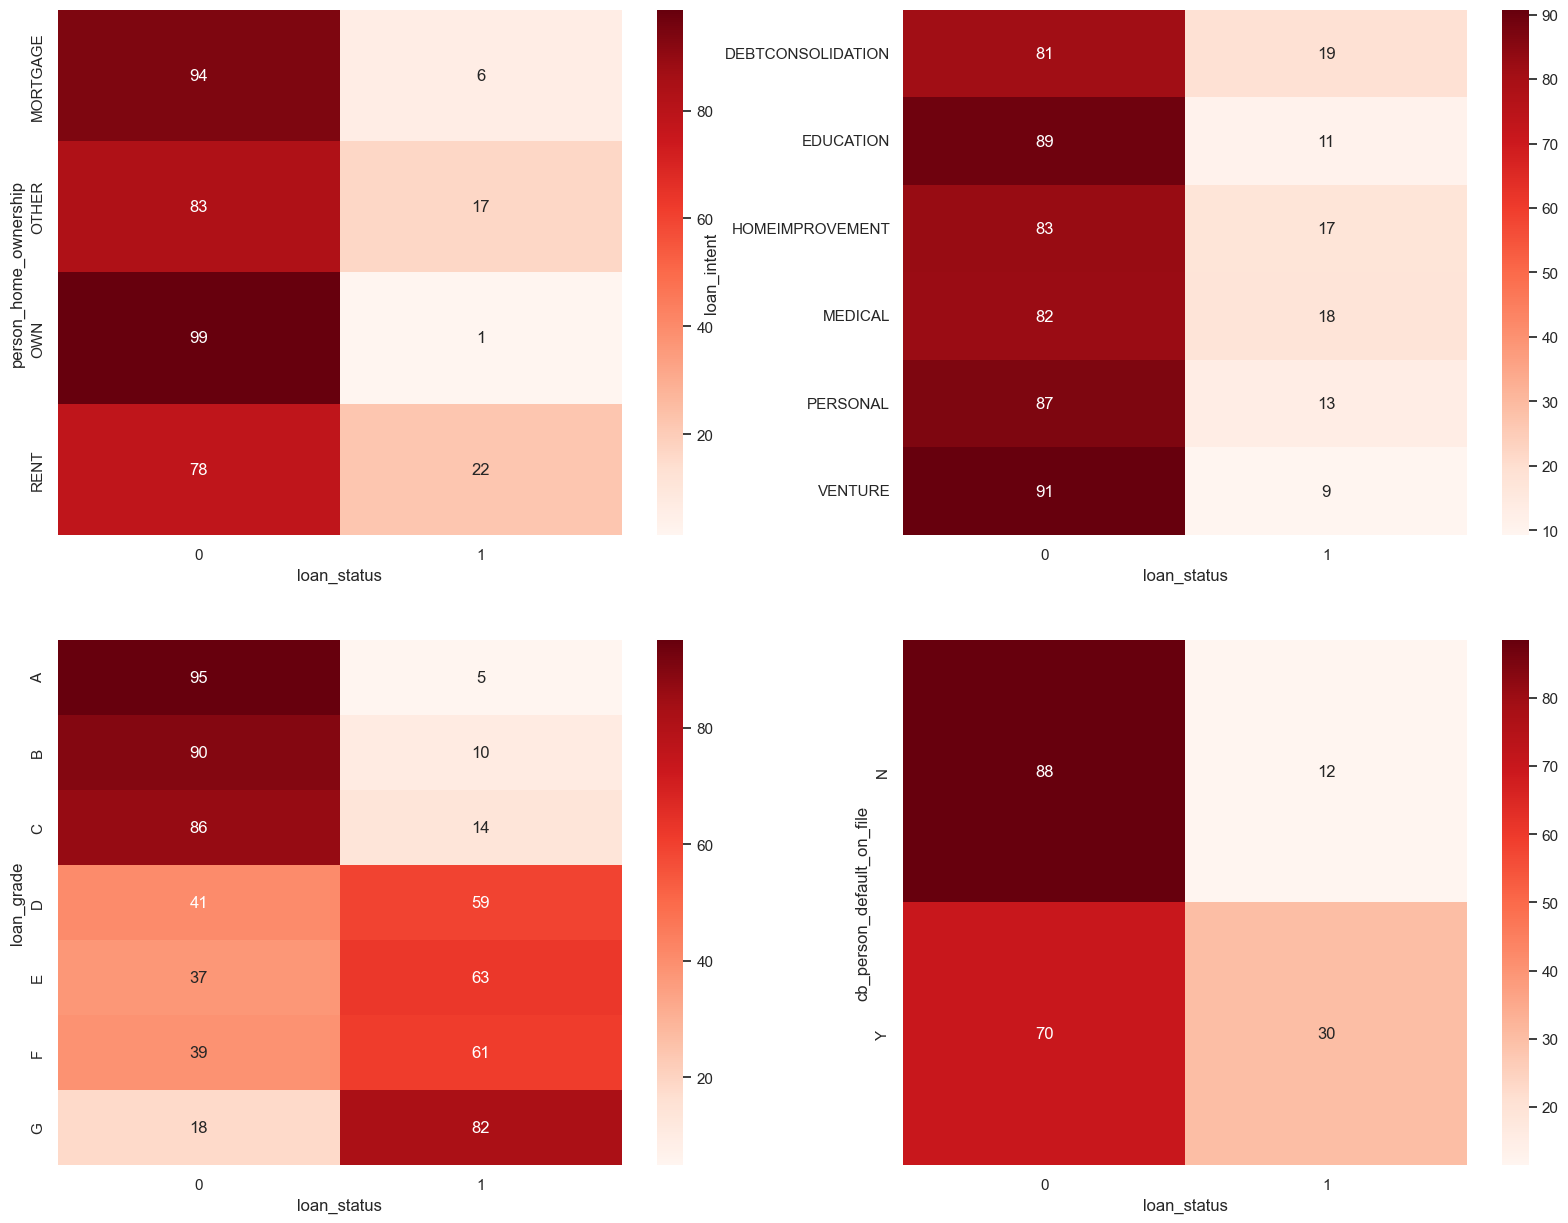

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot heatmaps
def plot_heatmap(data, feature, ax):
    cmap = sns.color_palette("Reds", as_cmap=True)
    sns.heatmap(data=round(100*pd.crosstab(train[feature], train['loan_status'], normalize=0), 2), 
                annot=True, cmap=cmap, fmt='.0f', ax=ax)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Plot each heatmap
plot_heatmap(train, 'person_home_ownership', axes[0, 0])
plot_heatmap(train, 'loan_intent', axes[0, 1])
plot_heatmap(train, 'loan_grade', axes[1, 0])
plot_heatmap(train, 'cb_person_default_on_file', axes[1, 1])

plt.show()

* In the loan_grade vs. loan_status plot, we observe that when the grade is D, E, F, or G, the likelihood of loan_status being 1 is significantly higher.
* “Y” in cb_person_default_on_file is associated with a greater likelihood of loan_status being 1.
* For person_home_ownership, “RENT” shows the highest probability of loan_status being 1.
* So far, loan_grade has proven to be highly informative!

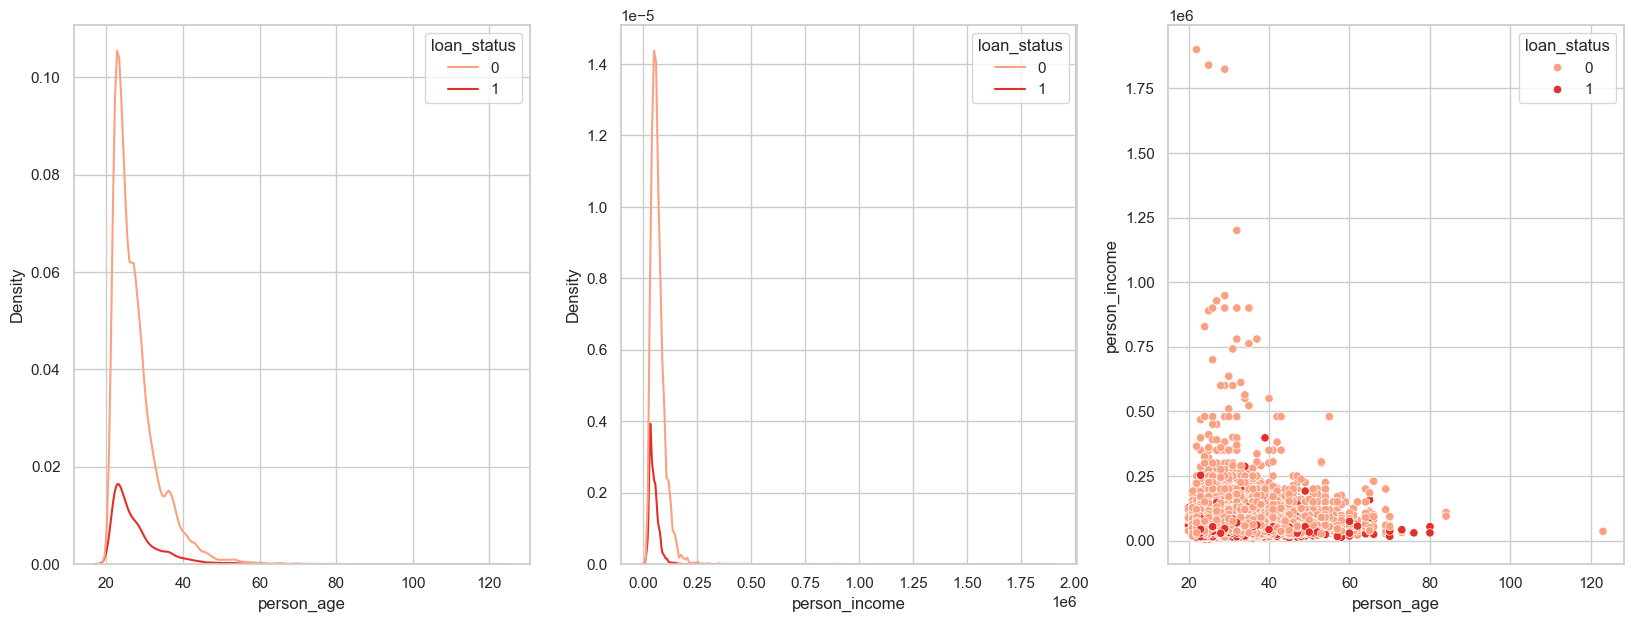

In [22]:
def plot_kde_or_scatter(data, x, y=None, plot_type='kde', ax=None, palette='Reds'):
    if plot_type == 'kde':
        sns.kdeplot(data=data, x=x, hue='loan_status', ax=ax, palette=palette)
    elif plot_type == 'scatter':
        sns.scatterplot(data=data, x=x, y=y, hue='loan_status', ax=ax, palette=palette)

# Subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

plot_kde_or_scatter(train, 'person_age', ax=axes[0], palette='Reds')
plot_kde_or_scatter(train, 'person_income', ax=axes[1], palette='Reds')
plot_kde_or_scatter(train, 'person_age', 'person_income', plot_type='scatter', ax=axes[2], palette='Reds')

plt.show()

* There is a person age above 120.

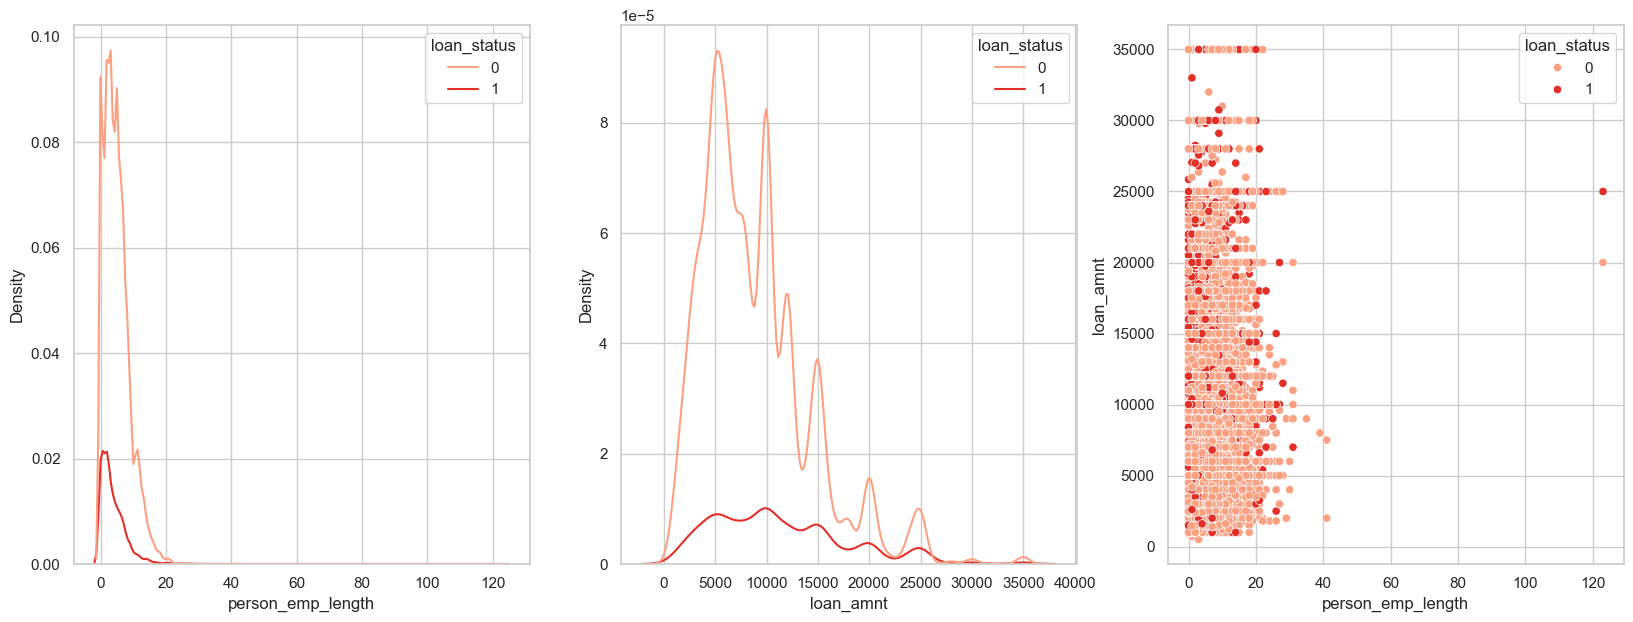

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

plot_kde_or_scatter(train, 'person_emp_length', ax=axes[0], palette='Reds')
plot_kde_or_scatter(train, 'loan_amnt', ax=axes[1], palette='Reds')
plot_kde_or_scatter(train, 'person_emp_length', 'loan_amnt', plot_type='scatter', ax=axes[2], palette='Reds')

plt.show()

* loan_status=0 and loan_status=1 has similiar distribution in both person_age, person_income, person_emp_length

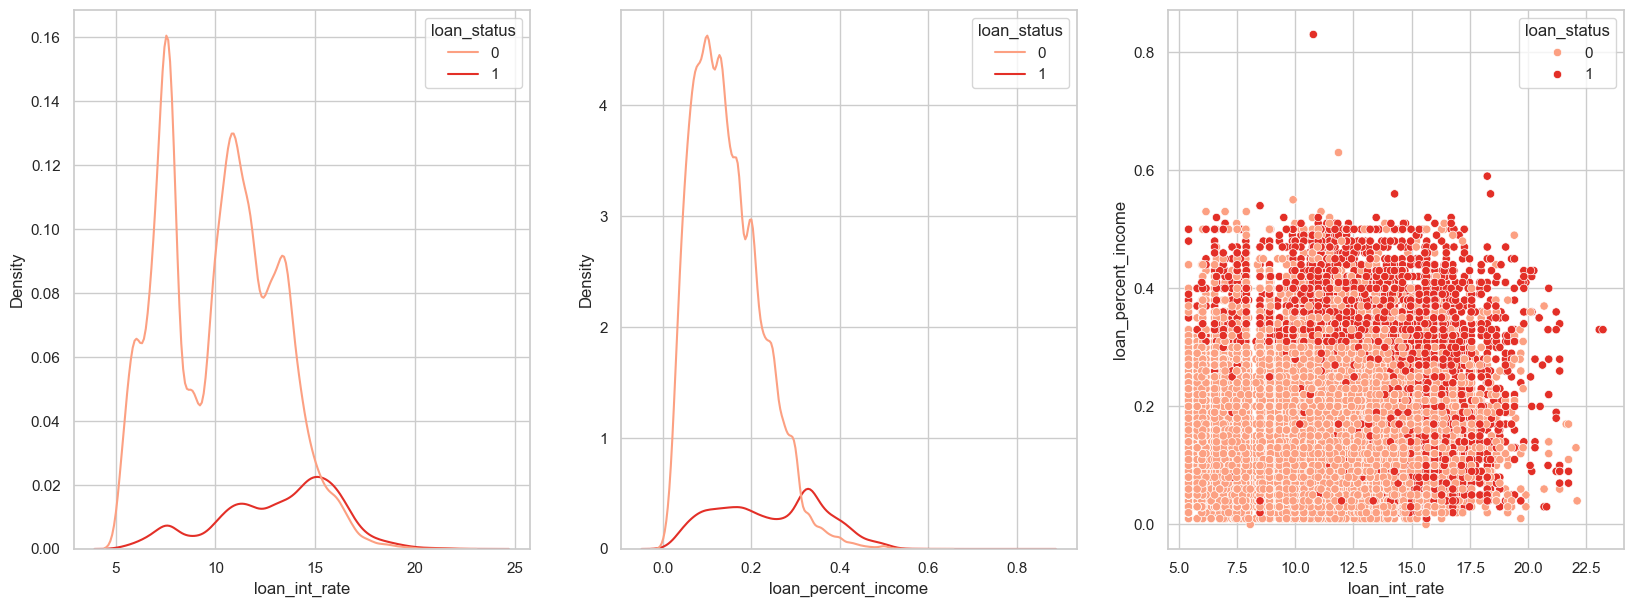

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

plot_kde_or_scatter(train, 'loan_int_rate', ax=axes[0], palette='Reds')
plot_kde_or_scatter(train, 'loan_percent_income', ax=axes[1], palette='Reds')
plot_kde_or_scatter(train, 'loan_int_rate', 'loan_percent_income', plot_type='scatter', ax=axes[2], palette='Reds')

plt.show()

* There are two loans with interest rate higher than 22.5.
* There are two loans with loan_percent_income higher than 0.6.
* loan_status = 1 has similar distribution in loan_int_rate and loan_percent_income.

# 4. Convert data

In [29]:
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Function to convert data types and clip values
def process_data(df, cat_cols, df_train=False):
    # Convert categorical columns to 'category' type
    df[cat_cols] = df[cat_cols].astype('category')

    # Convert other columns to optimized types
    df['person_age'] = df['person_age'].astype('int32')
    df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].astype('int32')

    if df_train:
        df['loan_status'] = df['loan_status'].astype('int8')

    # Clip values to handle outliers
    df['person_age'] = df['person_age'].clip(upper=90)
    df['person_emp_length'] = df['person_emp_length'].clip(upper=60)

    return df

# Process both train and test datasets
train = process_data(train, cat_cols, df_train=True)
test = process_data(test, cat_cols)

In [30]:
X = train.drop(columns=['loan_status'], axis=1)
Y = train['loan_status']

In [31]:
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# 5. Modelling

## 5.1. Random Forest Classifier

### 5.1.1. Hyperparameter Optimization

In [35]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

def prepare_data(df, cat_cols):
    dummies = pd.get_dummies(df[cat_cols], drop_first=True, dtype='int8')
    return pd.concat([df.drop(columns=cat_cols, axis=1), dummies], axis=1)

RF_train = prepare_data(X, cat_cols)
RF_test = prepare_data(test, cat_cols)

# Define the parameter grid for RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],       
    'max_depth': [10, 20, None],                     
    'min_samples_split': [2, 5],                         
    'min_samples_leaf': [1, 2, 4],                         
    'max_features': ['auto', 'sqrt', 'log2'],         
    'bootstrap': [True, False] 
}

rf = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=100, scoring='roc_auc', cv=5, 
                                   verbose=0, random_state=42, n_jobs=-1)

random_search.fit(RF_train, Y)
best_rf = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

scores, rf_oof_preds, rf_test_preds = [], [], []

# Cross-validation with Stratified KFold
for i, (train_index, test_index) in enumerate(skf.split(RF_train, Y)):
    
    X_train, X_test = RF_train.iloc[train_index], RF_train.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    rf_md = best_rf.fit(X_train, y_train)

    preds = rf_md.predict_proba(X_test)[:, 1]
    oof_preds = pd.DataFrame({'y': y_test.values, 'rf_preds': preds, 'fold': i})
    rf_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score for fold {i} is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame({'rf_preds': rf_md.predict_proba(RF_test)[:, 1], 'fold': i})
    rf_test_preds.append(test_preds)

rf_oof_score = np.mean(scores)
rf_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the optimized RandomForest model is {rf_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the optimized RandomForest model is {rf_std}")

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}
The oof ROC-AUC score for fold 0 is 0.9369488458470733
The oof ROC-AUC score for fold 1 is 0.9462334972202712
The oof ROC-AUC score for fold 2 is 0.940512612945084
The oof ROC-AUC score for fold 3 is 0.9390545350650588
The oof ROC-AUC score for fold 4 is 0.9363467101582125
The oof ROC-AUC score for fold 5 is 0.9394779738594
The oof ROC-AUC score for fold 6 is 0.9411037539159105
The oof ROC-AUC score for fold 7 is 0.9366645908818672
The oof ROC-AUC score for fold 8 is 0.9347220849611176
The oof ROC-AUC score for fold 9 is 0.9327543362271281
The 10-fold average oof ROC-AUC score of the optimized RandomForest model is 0.9383818941081123
The 10-fold std oof ROC-AUC score of the optimized RandomForest model is 0.003598031875623991
CPU times: user 1min 57s, sys: 1.55 s, total: 1min 58s
Wall time: 8min 36s


### 5.1.2. Using Best Parameters in the Model

In [37]:
%%time

# Function to create dummy variables and merge them back with the original dataset
def prepare_data(df, cat_cols):
    dummies = pd.get_dummies(df[cat_cols], drop_first=True, dtype='int8')
    return pd.concat([df.drop(columns=cat_cols, axis=1), dummies], axis=1)

RF_train = prepare_data(X, cat_cols)
RF_test = prepare_data(test, cat_cols)

rf_params = {
    'n_estimators': 300,          
    'max_depth': None,           
    'min_samples_split': 2,       
    'min_samples_leaf': 4,             
    'max_features': 'sqrt',            
    'bootstrap': True,      
    'n_jobs': -1                       
}


scores, rf_oof_preds, rf_test_preds = [], [], []

for i, (train_index, test_index) in enumerate(skf.split(RF_train, Y)):
    
    X_train, X_test = RF_train.iloc[train_index], RF_train.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    rf_md = RandomForestClassifier(**rf_params).fit(X_train, y_train)
    
    preds = rf_md.predict_proba(X_test)[:, 1]
    oof_preds = pd.DataFrame({'y': y_test.values, 'rf_preds': preds, 'fold': i})
    rf_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame({'rf_preds': rf_md.predict_proba(RF_test)[:, 1], 'fold': i})
    rf_test_preds.append(test_preds)

rf_oof_score = np.mean(scores)
rf_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the RandomForest model is {rf_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the RandomForest model is {rf_std}")

The oof ROC-AUC score is 0.9371147962524257
The oof ROC-AUC score is 0.9461484982321638
The oof ROC-AUC score is 0.9376069332507947
The oof ROC-AUC score is 0.9383038297163129
The oof ROC-AUC score is 0.9353824359233819
The oof ROC-AUC score is 0.93893311011701
The oof ROC-AUC score is 0.9412147270382678
The oof ROC-AUC score is 0.9361890258060137
The oof ROC-AUC score is 0.9342903375988132
The oof ROC-AUC score is 0.9323656921591297
The 10-fold average oof ROC-AUC score of the RandomForest model is 0.9377549386094313
The 10-fold std oof ROC-AUC score of the RandomForest model is 0.00365610894056321
CPU times: user 2min 24s, sys: 1.11 s, total: 2min 26s
Wall time: 20 s


## 5.2. LightGBM Classifier

### 5.2.1. Hyperparameter Optimization

In [40]:
%%time

param_grid = {
    'learning_rate': [0.01, 0.03, 0.1],
    'n_estimators': [100, 150, 200, 300],
    'max_depth': [10, 15, 20, None],
    'reg_alpha': [0.01, 0.1, 0.25],
    'reg_lambda': [0.01, 0.05, 0.1],
    'num_leaves': [31, 38, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'n_jobs': [-1]
}

lgb = LGBMClassifier(verbose=-1)
random_search = RandomizedSearchCV(estimator=lgb, param_distributions=param_grid, 
                                   n_iter=100, scoring='roc_auc', cv=5, 
                                   verbose=0, random_state=42, n_jobs=-1)

random_search.fit(X, Y)
best_lgb = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

scores, lgb_oof_preds, lgb_test_preds = [], [], []

for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    lgb_md = best_lgb.fit(X_train, y_train)
    
    preds = lgb_md.predict_proba(X_test)[:, 1]
    lgb_oof_preds.append(pd.DataFrame({'y': y_test.values, 'lgb_preds': preds, 'fold': i}))
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    lgb_test_preds.append(pd.DataFrame({'lgb_preds': lgb_md.predict_proba(test)[:, 1], 'fold': i}))

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the optimized LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the optimized LGBM model is {lgb_std}")

Best Hyperparameters: {'reg_lambda': 0.01, 'reg_alpha': 0.25, 'num_leaves': 100, 'n_jobs': -1, 'n_estimators': 300, 'max_depth': None, 'learning_rate': 0.03, 'colsample_bytree': 0.5}
The oof ROC-AUC score is 0.9594083403769004
The oof ROC-AUC score is 0.9611190342972107
The oof ROC-AUC score is 0.9590104879703814
The oof ROC-AUC score is 0.9557595742907824
The oof ROC-AUC score is 0.9572214616492661
The oof ROC-AUC score is 0.9606797937233507
The oof ROC-AUC score is 0.9573772717043544
The oof ROC-AUC score is 0.9581295551668587
The oof ROC-AUC score is 0.9535360775764041
The oof ROC-AUC score is 0.9586684654155597
The 10-fold average oof ROC-AUC score of the optimized LGBM model is 0.9580910062171067
The 10-fold std oof ROC-AUC score of the optimized LGBM model is 0.002150232787306621
CPU times: user 41.6 s, sys: 47.1 s, total: 1min 28s
Wall time: 8min 12s


### 5.2.2. Using Best Parameters in the Model

In [41]:
%%time
# LightGBM parameters
lgb_params = {
    'learning_rate': 0.03,
    'n_estimators': 300,
    'max_depth': None,
    'reg_alpha': 0.25,
    'reg_lambda': 0.01,
    'num_leaves': 100,
    'colsample_bytree': 0.5,
    'n_jobs': -1
}

scores, lgb_oof_preds, lgb_test_preds = [], [], []

for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    # Training
    lgb_md = LGBMClassifier(**lgb_params).fit(X_train, y_train)
    
    # Predictions
    preds = lgb_md.predict_proba(X_test)[:, 1]
    lgb_oof_preds.append(pd.DataFrame({'y': y_test.values, 'lgb_preds': preds, 'fold': i}))
    
    # ROC-AUC score
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    # Test predictions
    lgb_test_preds.append(pd.DataFrame({'lgb_preds': lgb_md.predict_proba(test)[:, 1], 'fold': i}))

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM model is {lgb_std}")

[LightGBM] [Info] Number of positive: 7515, number of negative: 45265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 52780, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142383 -> initscore=-1.795633
[LightGBM] [Info] Start training from score -1.795633
The oof ROC-AUC score is 0.9594083403769004
[LightGBM] [Info] Number of positive: 7515, number of negative: 45265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1097
[LightGBM] [Info] Number of data points in the train set: 52780, numb

## 5.3. XGBoost Classifier

### 5.3.1. Hyperparameter Optimization

In [44]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 12, 15],
    'learning_rate': [0.01, 0.03, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 5, 10, 20],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'enable_categorical': [True],
    'n_jobs': [-1]
}

xgb = XGBClassifier()
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, 
                                   n_iter=100, scoring='roc_auc', cv=5, 
                                   verbose=0, random_state=42, n_jobs=-1)

random_search.fit(X, Y)
best_xgb = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

scores, xgb_oof_preds, xgb_test_preds = [], [], []

for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    xgb_md = best_xgb.fit(X_train, y_train)
    
    preds = xgb_md.predict_proba(X_test)[:, 1]
    xgb_oof_preds.append(pd.DataFrame({'y': y_test.values, 'xgb_preds': preds, 'fold': i}))
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    xgb_test_preds.append(pd.DataFrame({'xgb_preds': xgb_md.predict_proba(test)[:, 1], 'fold': i}))

xgb_oof_score = np.mean(scores)
xgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the optimized XGBoost model is {xgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the optimized XGBoost model is {xgb_std}")

Best Hyperparameters: {'n_jobs': -1, 'n_estimators': 300, 'min_child_weight': 20, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.3, 'enable_categorical': True, 'colsample_bytree': 0.5}
The oof ROC-AUC score is 0.9579885953738647
The oof ROC-AUC score is 0.9589378697872644
The oof ROC-AUC score is 0.9550438685253746
The oof ROC-AUC score is 0.9526241354269592
The oof ROC-AUC score is 0.9563326627063963
The oof ROC-AUC score is 0.957373699608141
The oof ROC-AUC score is 0.9545003054142261
The oof ROC-AUC score is 0.9582371943327502
The oof ROC-AUC score is 0.9536034711249602
The oof ROC-AUC score is 0.9557026729995964
The 10-fold average oof ROC-AUC score of the optimized XGBoost model is 0.9560344475299534
The 10-fold std oof ROC-AUC score of the optimized XGBoost model is 0.0019991989534248523
CPU times: user 19.6 s, sys: 7.72 s, total: 27.3 s
Wall time: 1min 58s


### 5.3.2. Using Best Parameters in the Model

In [45]:
%%time
xgb_params = {
    'n_estimators': 300,
    'max_depth': 12,
    'learning_rate': 0.1,
    'gamma': 0.3,
    'min_child_weight': 20,
    'colsample_bytree': 0.5,
    'n_jobs': -1,
    'enable_categorical': True
}

scores, xgb_oof_preds, xgb_test_preds = [], [], []

for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    xgb_md = XGBClassifier(**xgb_params).fit(X_train, y_train)
    
    preds = xgb_md.predict_proba(X_test)[:, 1]
    xgb_oof_preds.append(pd.DataFrame({'y': y_test.values, 'xgb_preds': preds, 'fold': i}))
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    xgb_test_preds.append(pd.DataFrame({'xgb_preds': xgb_md.predict_proba(test)[:, 1], 'fold': i}))

xgb_oof_score = np.mean(scores)
xgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the XGBoost model is {xgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the XGBoost model is {xgb_std}")

The oof ROC-AUC score is 0.9579885953738647
The oof ROC-AUC score is 0.9589378697872644
The oof ROC-AUC score is 0.9550438685253746
The oof ROC-AUC score is 0.9526241354269592
The oof ROC-AUC score is 0.9563326627063963
The oof ROC-AUC score is 0.957373699608141
The oof ROC-AUC score is 0.9545003054142261
The oof ROC-AUC score is 0.9582371943327502
The oof ROC-AUC score is 0.9536034711249602
The oof ROC-AUC score is 0.9557026729995964
The 10-fold average oof ROC-AUC score of the XGBoost model is 0.9560344475299534
The 10-fold std oof ROC-AUC score of the XGBoost model is 0.0019991989534248523
CPU times: user 16.5 s, sys: 5.54 s, total: 22 s
Wall time: 6.77 s


## 5.4. Combine predictions

In [47]:
%%time

# Combine predictions into DataFrame
oof_preds = pd.concat([pd.concat(lgb_oof_preds), 
                       pd.concat(xgb_oof_preds)['xgb_preds'],
                       pd.concat(rf_oof_preds)['rf_preds']], axis=1)


optuna.logging.set_verbosity(optuna.logging.ERROR)

# Objective function for Optuna 
def objective(trial):
    
    weights = [trial.suggest_float(f"weight{n}", 1e-5, 1) for n in range(4)]
    scores = [
        roc_auc_score(
            oof_preds[oof_preds['fold'] == i]['y'],
            sum(weights[j] * oof_preds[oof_preds['fold'] == i][f'{model}_preds'] for j, model in enumerate(['lgb', 'xgb', 'rf'])))
        for i in range(10)]
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=-1)

CPU times: user 38.6 s, sys: 10.6 s, total: 49.2 s
Wall time: 29.2 s


In [48]:
best_trial = study.best_trial
print(f"Best Trial:\n  Value: {best_trial.value}\n  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 0.9585954833094587
  Params:
    weight0: 0.9079203817737782
    weight1: 0.3635289404534459
    weight2: 6.063732691970506e-05
    weight3: 0.2449804144326853


In [49]:
w = study.best_trial.params
scores = []

for i in range(10):

    x_train = oof_preds[oof_preds['fold'] != i].drop(columns=['fold', 'y']).reset_index(drop=True)
    y_train = oof_preds[oof_preds['fold'] != i]['y'].reset_index(drop=True)
    
    x_test = oof_preds[oof_preds['fold'] == i].drop(columns=['fold', 'y']).reset_index(drop=True)
    y_test = oof_preds[oof_preds['fold'] == i]['y'].reset_index(drop=True)
    
    optuna_pred = sum(w[f'weight{j}'] * oof_preds[oof_preds['fold'] == i][f'{model}_preds'] 
                      for j, model in enumerate(['lgb', 'xgb', 'rf']))

    scores.append(roc_auc_score(y_test, optuna_pred))

results = pd.DataFrame()
results['Model'] = ['RF', 'LGBM', 'XGB', 'Optuna Blend']
results['10-fold oof ROC-AUC'] = [rf_oof_score, lgb_oof_score, xgb_oof_score, np.mean(scores)] 
print(results)

          Model  10-fold oof ROC-AUC
0            RF             0.937755
1          LGBM             0.958091
2           XGB             0.956034
3  Optuna Blend             0.958595


# 6. Conclusion

Based on the results above, the Optuna Blend demonstrates a superior out-of-fold ROC-AUC score. Therefore, we will use the Optuna Blend strategy to combine the predictions on the test dataset.

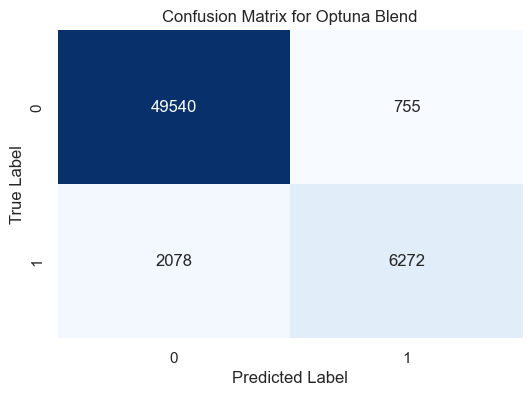

          Model  10-fold oof ROC-AUC
0            RF             0.937755
1          LGBM             0.958091
2           XGB             0.956034
3  Optuna Blend             0.958595


In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

w = study.best_trial.params
scores = []
all_y_true = []
all_y_pred = []

for i in range(10):

    x_train = oof_preds[oof_preds['fold'] != i].drop(columns=['fold', 'y']).reset_index(drop=True)
    y_train = oof_preds[oof_preds['fold'] != i]['y'].reset_index(drop=True)
    
    x_test = oof_preds[oof_preds['fold'] == i].drop(columns=['fold', 'y']).reset_index(drop=True)
    y_test = oof_preds[oof_preds['fold'] == i]['y'].reset_index(drop=True)
    

    optuna_pred = sum(w[f'weight{j}'] * oof_preds[oof_preds['fold'] == i][f'{model}_preds'] 
                      for j, model in enumerate(['lgb', 'xgb', 'rf']))
    
    all_y_true.extend(y_test)
    all_y_pred.extend((optuna_pred > 0.5).astype(int))  


    scores.append(roc_auc_score(y_test, optuna_pred))

cm = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Optuna Blend')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

results = pd.DataFrame({
    'Model': ['RF', 'LGBM', 'XGB', 'Optuna Blend'],
    '10-fold oof ROC-AUC': [rf_oof_score, lgb_oof_score, xgb_oof_score, np.mean(scores)]
})
print(results)


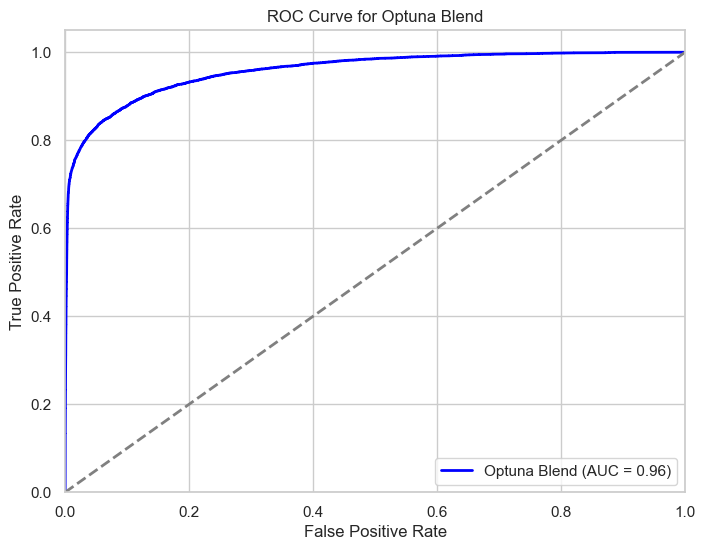

In [53]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

all_y_true = []
all_optuna_preds = []

for i in range(10):
    x_test = oof_preds[oof_preds['fold'] == i].drop(columns=['fold', 'y']).reset_index(drop=True)
    y_test = oof_preds[oof_preds['fold'] == i]['y'].reset_index(drop=True)
    
    optuna_pred = sum(w[f'weight{j}'] * oof_preds[oof_preds['fold'] == i][f'{model}_preds'] 
                      for j, model in enumerate(['lgb', 'xgb', 'rf']))
    
    all_y_true.extend(y_test)
    all_optuna_preds.extend(optuna_pred)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_y_true, all_optuna_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Optuna Blend (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optuna Blend')
plt.legend(loc="lower right")
plt.show()